# Notebook configuration

In [1]:
Kr_outputfolder  = "/Users/Gonzalo/Desktop/ReportPlots/Kr/"
XR_outputfolder  = "/Users/Gonzalo/Desktop/ReportPlots/XR/"
PE_outputfolder  = "/Users/Gonzalo/Desktop/ReportPlots/PE/"
save_plots       = True

KrDST = "/Users/Gonzalo/github/NEXTdata/Kr/run3389.dst"
NaDST = "/Users/Gonzalo/github/NEXTdata/Na22/run3614.dst"

In [2]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy             as scp
import scipy.interpolate

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Fri Apr 28 21:35:54 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 10, 8
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"

for outputfolder in [Kr_outputfolder, XR_outputfolder, PE_outputfolder]:
    if not os.path.exists(outputfolder):
        os.mkdir(outputfolder)

#### Useful functions

In [4]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange, *args, **kwargs)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), weights=z_), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr


def get_tcorr(ts, es, t0 = 0, eref=None):
    if eref is None:
        eref = np.max(es)
    ts   = ts.reshape(ts.size, 1) + t0
    print(eref)
    def tcorr(t):
        t_closest = np.apply_along_axis(np.argmin, 0, abs(t-ts))
        e = es[t_closest]
        return eref/ e
    return tcorr


save = functools.partial(save_to_folder, save_plots, outputfolder)

# Kr

### Waveform

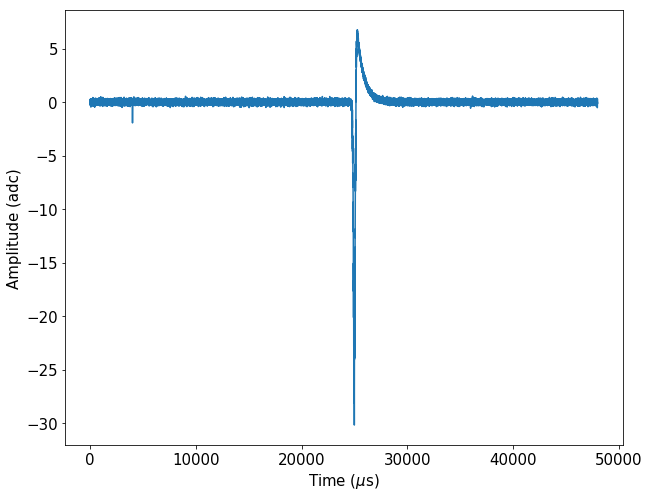

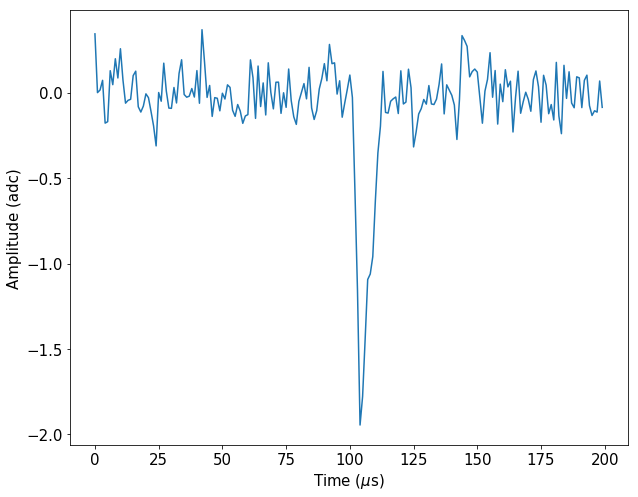

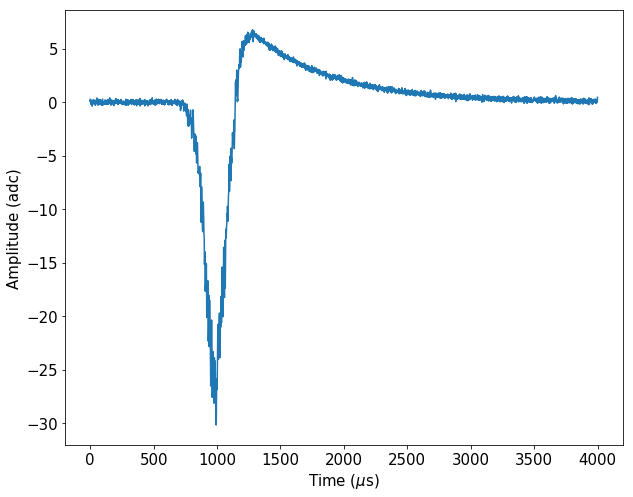

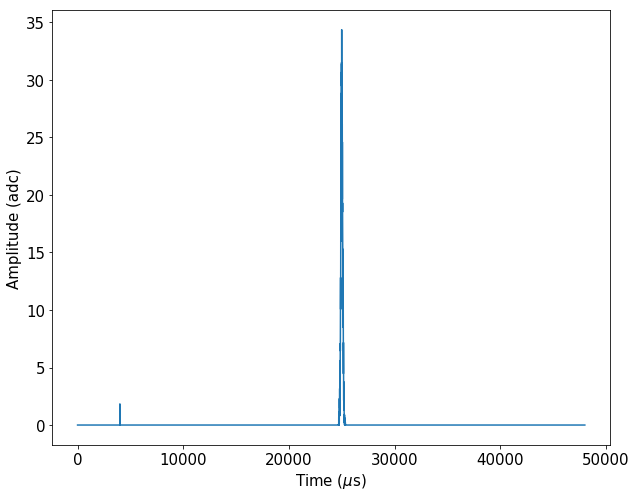

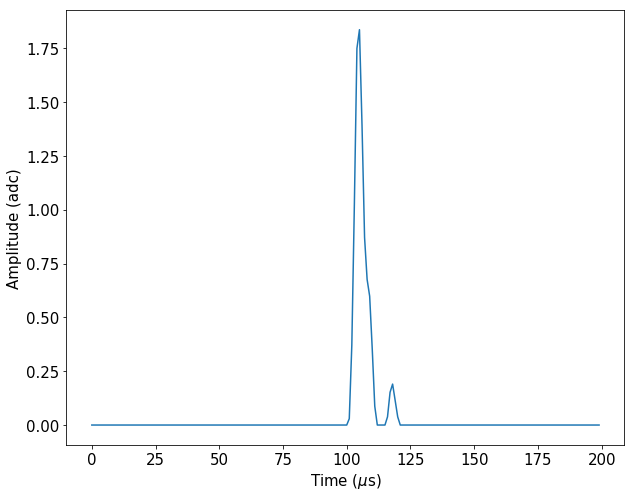

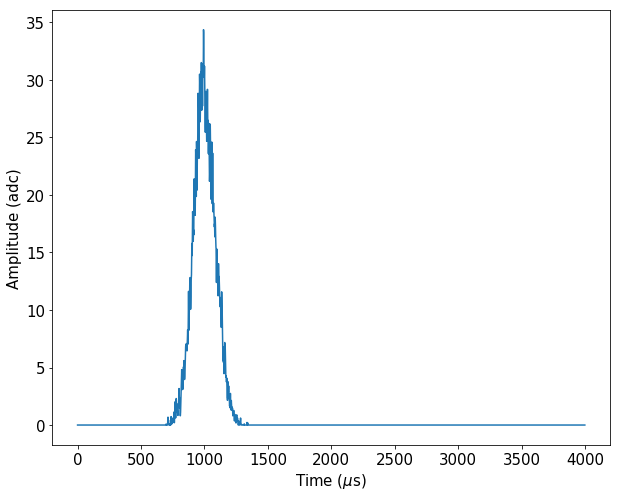

In [5]:
import tables as tb
import invisible_cities.database.load_db as db

h5f = tb.open_file("/Users/Gonzalo/github/NEXTdata/_Kr2016/mar/rwf/dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_RWF_10000.root.h5")

rwfs = h5f.root.RD.pmtrwf
cwfs = h5f.root.RD.pmtblr
pmts = db.DataPMT(0)

evt = 0
rwf = rwfs[evt]
rwf = np.sum((rwf - np.mean(rwf, axis=1).reshape(12,1)) / abs(pmts.adc_to_pes.values).reshape(12, 1), axis=0)
cwf = np.sum(cwfs[evt] / abs(pmts.adc_to_pes.values).reshape(12, 1), axis=0)

for wf in [rwf, cwf]:
    plt.figure()
    plt.plot(wf)
    labels("Time ($\mu$s)", "Amplitude (adc)")

    plt.figure()
    plt.plot(wf[3900:4100])
    labels("Time ($\mu$s)", "Amplitude (adc)")

    plt.figure()
    plt.plot(wf[24000:28000])
    labels("Time ($\mu$s)", "Amplitude (adc)")

h5f.close()

In [6]:
kr = dstf.load_dst(KrDST, "DST", "Events")
kr.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,10,1.490299e+09,0,1,175.0,2.001530,9.195722,526500.0,7.850000,1760.124390,...,653187.5,3,126.6875,126.6875,121.761582,27.240410,124.771483,0.220095,4.694699,4.18312
1,12,1.490299e+09,0,1,350.0,1.333540,11.618336,492175.0,8.207313,1114.189697,...,652712.5,2,160.5375,160.5375,-110.719067,35.000000,116.119386,2.835417,4.977362,0.00000
2,14,1.490299e+09,0,1,275.0,1.316907,6.871000,576350.0,6.079562,1886.400269,...,652537.5,2,76.1875,76.1875,-175.000000,-59.651885,184.887391,-2.813076,0.000000,5.00644
3,18,1.490299e+09,0,1,200.0,2.950729,13.812014,587900.0,5.989813,2827.022949,...,652412.5,4,64.5125,64.5125,-15.027502,-46.712307,49.070005,-1.882044,6.028039,3.77384
4,24,1.490299e+09,0,1,100.0,1.287624,4.552865,504525.0,8.008188,1226.703369,...,652837.5,2,148.3125,148.3125,0.927833,5.000000,5.085359,1.387317,4.943756,0.00000


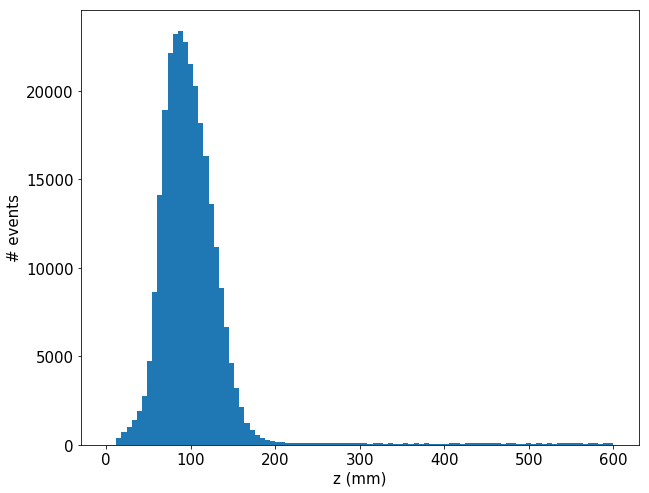

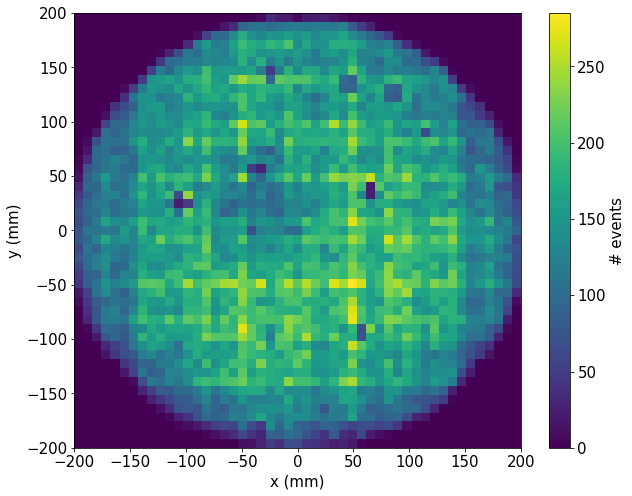

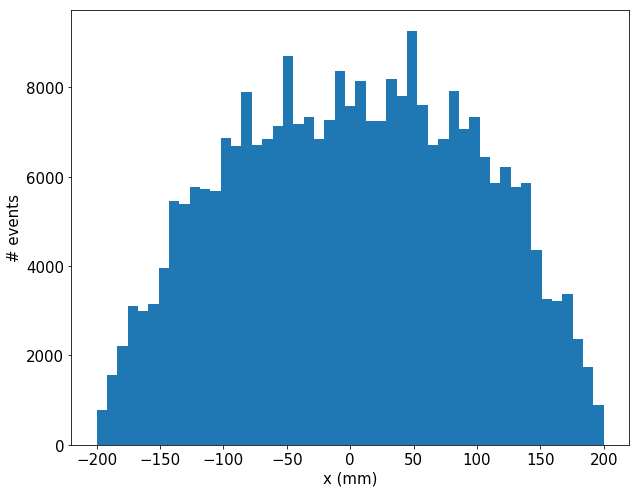

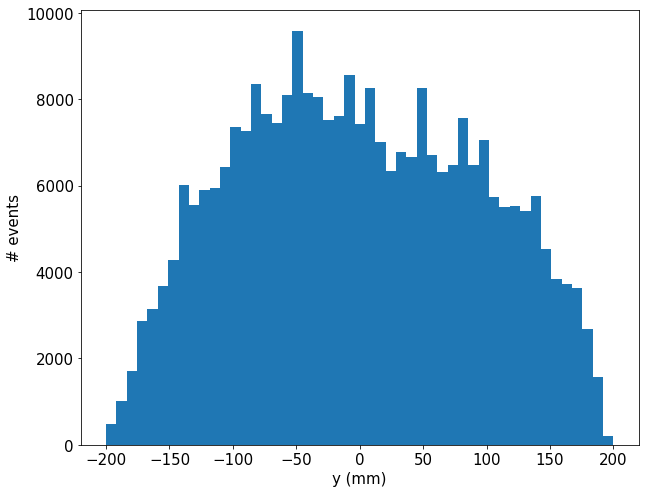

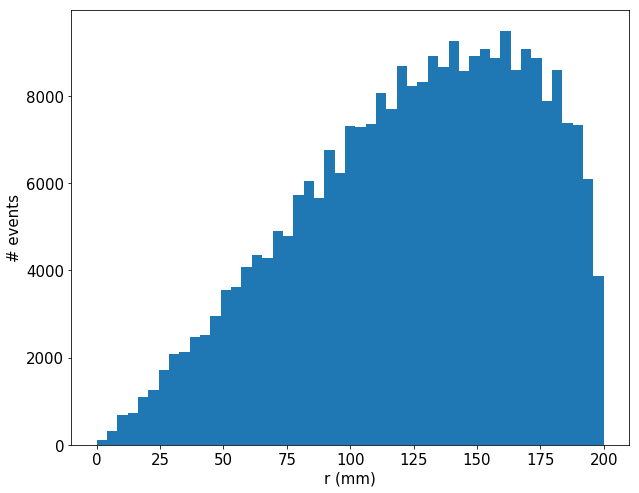

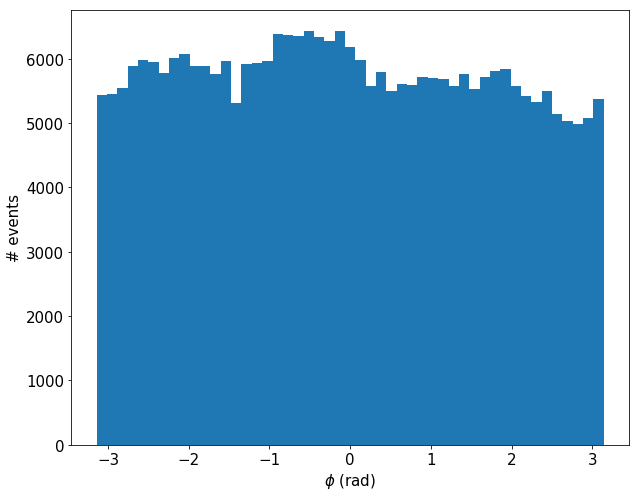

In [7]:
hist(kr.Z.values, np.linspace(0, 600, 100))
labels("z (mm)", "# events")

hist2d(kr.X.values, kr.Y.values, (np.linspace(-200, 200, 50),
                                  np.linspace(-200, 200, 50)))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

hist(kr.X.values, np.linspace(-200, 200, 50))
labels("x (mm)", "# events")

hist(kr.Y.values, np.linspace(-200, 200, 50))
labels("y (mm)", "# events")

hist(kr.R.values, np.linspace(0, 200, 50))
labels("r (mm)", "# events")

hist(kr.Phi.values, np.linspace(-pi, pi, 50))
labels("$\phi$ (rad)", "# events")

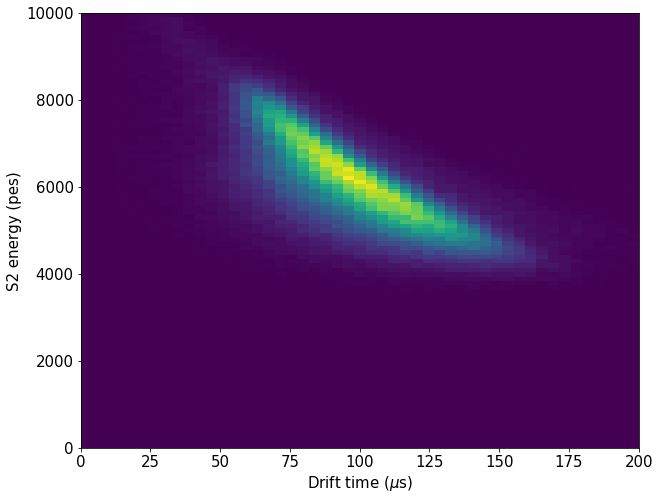

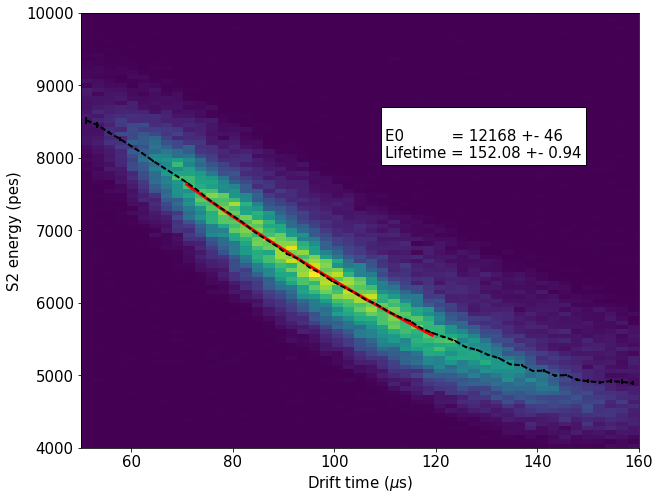

In [8]:
hist2d(kr.Z.values, kr.S2e.values, (np.linspace(0, 200,  50),
                                    np.linspace(0, 1e4, 100)))
#plt.colorbar().set_label("# events")
labels("Drift time ($\mu$s)", "S2 energy (pes)")

fid = kr[kr.R < 100]
hist2d(fid.Z.values, fid.S2e.values, (np.linspace( 50, 160,  50),
                                      np.linspace(4e3, 1e4, 100)))
x, y, ye = fitf.profileX(fid.Z.values, fid.S2e.values, 50, (50, 160), (4e3, 1e4))
plt.errorbar(x, y, ye, fmt=profOpt, lw=2)

sel = coref.in_range(x, 70, 120)
f = fitf.fit(fitf.expo, x, y, (1e4, -2e2), sigma=ye[sel], fit_range=(70, 120))
plt.plot(x[sel], f.fn(x[sel]), fitOpt, lw=3)
plt.text(110, 8e3, """
E0          = {:.0f} +- {:.0f}
Lifetime = {:.2f} +- {:.2f}""".format( f.values[0], f.errors[0],
                                      -f.values[1], f.errors[1]), bbox=dict(facecolor='white'))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

zref = 50
LT = -f.values[1]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


8632.84772472


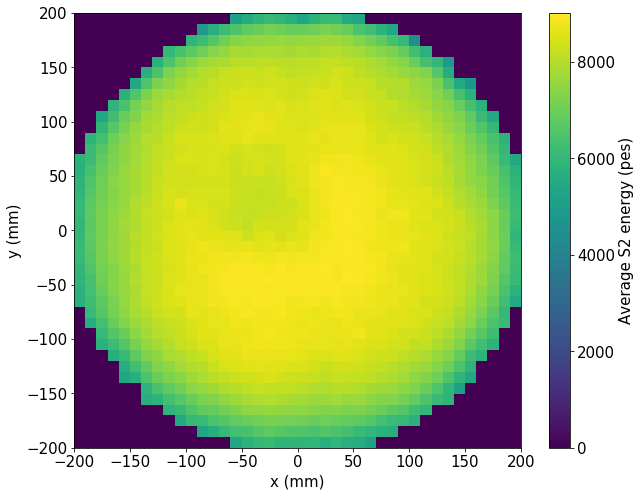

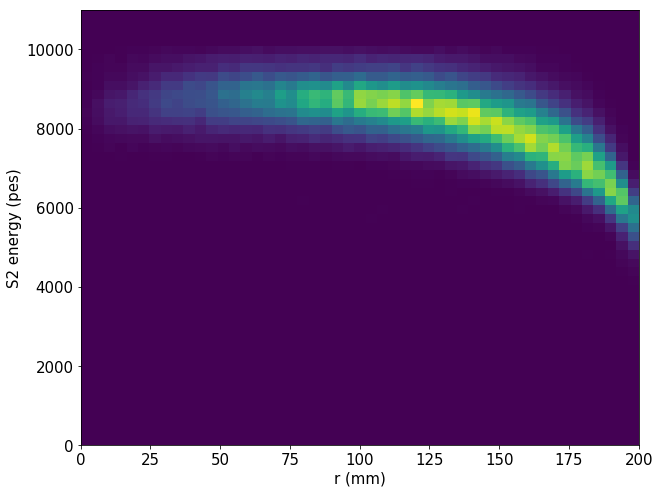

In [9]:
fid = kr [coref.in_range(kr.Z.values, 0, 200)]
fid.S2e *= np.exp((fid.Z.values - zref)/LT)
fid = fid[coref.in_range(fid.S2e.values, 4e3, 1e4)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]
#hist2d(fid.Z, fid.S2e, 100, ((0, 200), (4e3, 12e3)))
#hist(fid.S2e, 100, (4e3, 12e3))

pf, _, cb = profile_and_scatter(fid.X.values, fid.Y.values, fid.S2e.values,
                                (40, 40), (-200, 200), (-200, 200))
cb.set_label("Average S2 energy (pes)")
labels("x (mm)", "y (mm)")

hist2d(fid.R.values, fid.S2e.values, (np.linspace( 0,  200, 50),
                                      np.linspace( 0, 11e3, 50)))
labels("r (mm)", "S2 energy (pes)")


xycorr = get_xycorr(*pf[:-1])

[  1.82613981e+07   8.64221097e+03   5.49147114e+02] 33.2218720916 (14.932471810806003, 1.9402818119229932)


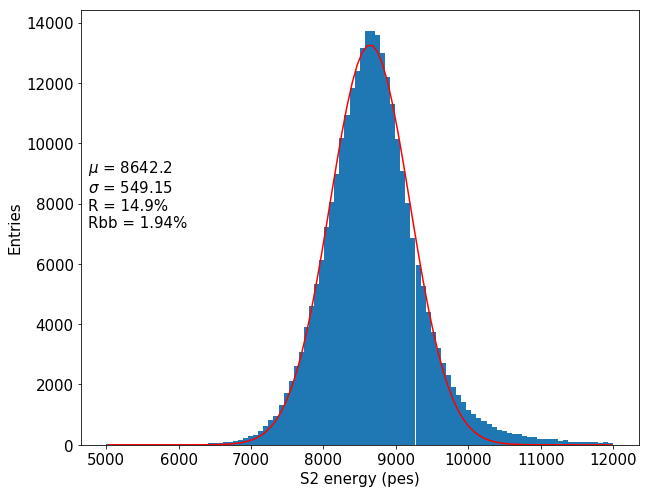

In [10]:
fid = kr [coref.in_range(kr.Z.values, 0, 200)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]

fid.S2e *= np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

y, x, _ = \
hist(fid.S2e, 100, (5e3, 12e3))
x = x[:-1] + np.diff(x) * 0.5

f = fitf.fit(fitf.gauss, x, y, (1e6, 8e3, 1e2), fit_range=(7e3, 1e4))
plt.plot(x, f.fn(x), fitOpt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values, 41.5))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values, 41.5))

9285.54062288


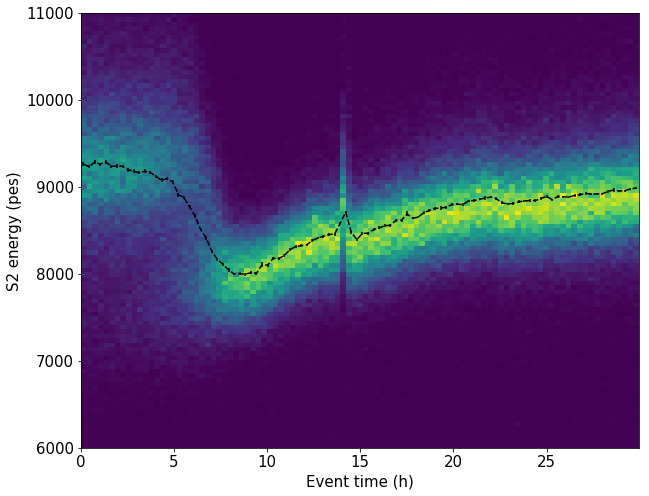

In [11]:
fid = kr [coref.in_range(kr.Z.values, 0, 200)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]

T  = fid.time / 3600
T -= np.min(T)
E  = fid.S2e * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

hist2d(T, E, (np.linspace(  0, np.max(T), 100),
              np.linspace(6e3,      11e3, 100)))

x, y, ye = fitf.profileX(T, E, 100, (0, np.max(T)))
plt.errorbar(x, y, ye, fmt=profOpt)
labels("Event time (h)", "S2 energy (pes)")

tcorr = get_tcorr(x, y)

[  1.72746382e+07   9.22003684e+03   4.00723174e+02] 26.0804874007 (10.213619265957682, 1.3271278825588015)


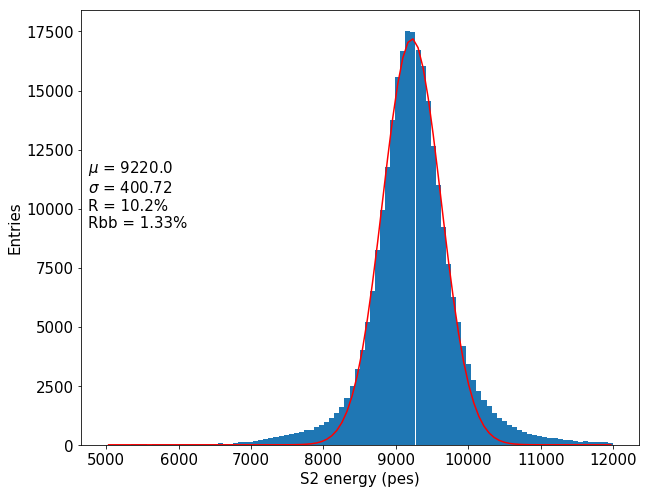

In [12]:
fid = kr [coref.in_range(kr.Z.values, 0, 200)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]

T  = fid.time.values / 3600
T -= np.min(T)
E  = fid.S2e.values * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values) * tcorr(T)

y, x, _ = \
hist(E, 100, (5e3, 12e3))
x = x[:-1] + np.diff(x) * 0.5

f = fitf.fit(fitf.gauss, x, y, (1e6, 8e3, 1e2), fit_range=(8300, 1e4))
plt.plot(x, f.fn(x), fitOpt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values, 41.5))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values, 41.5))

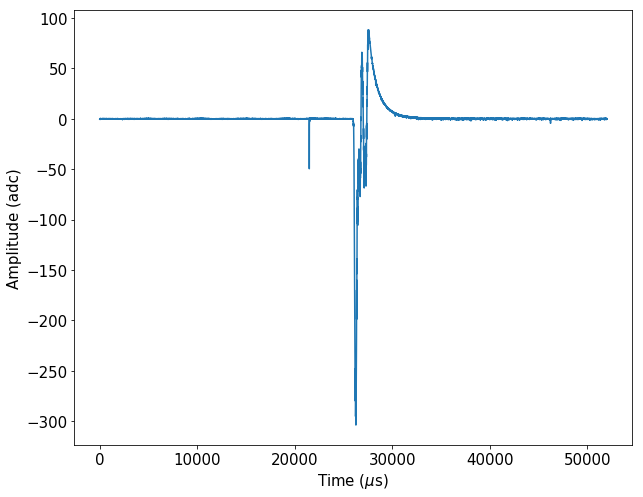

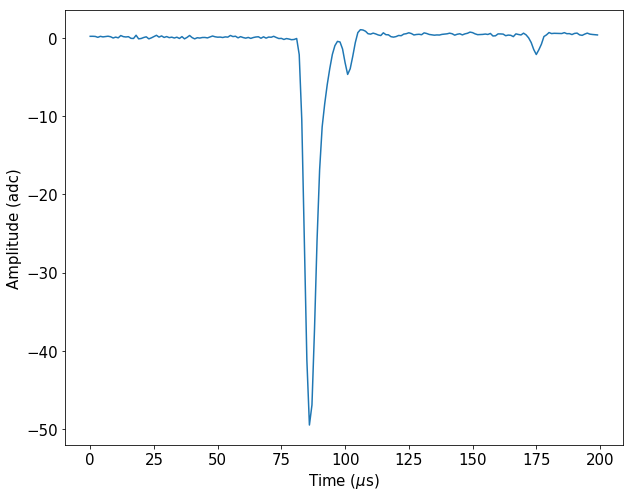

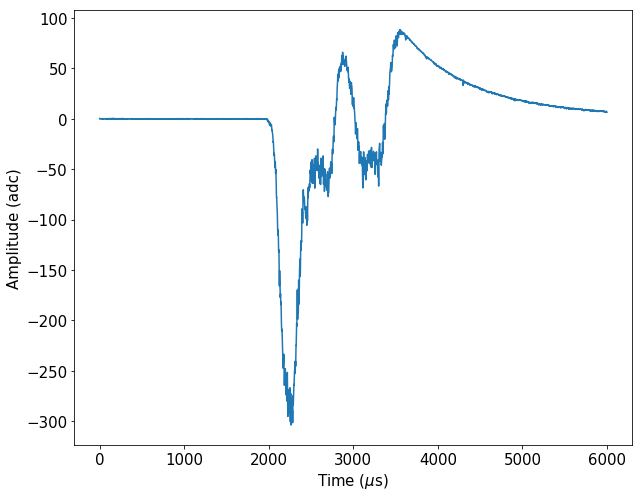

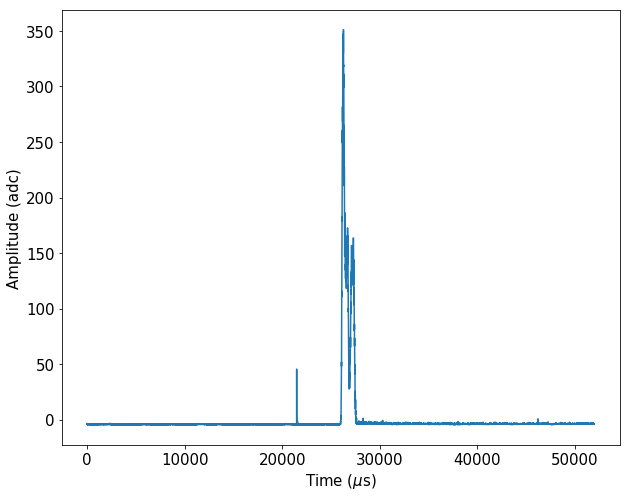

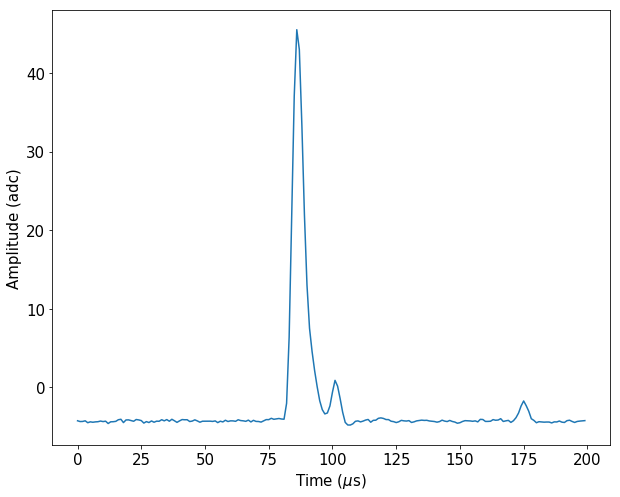

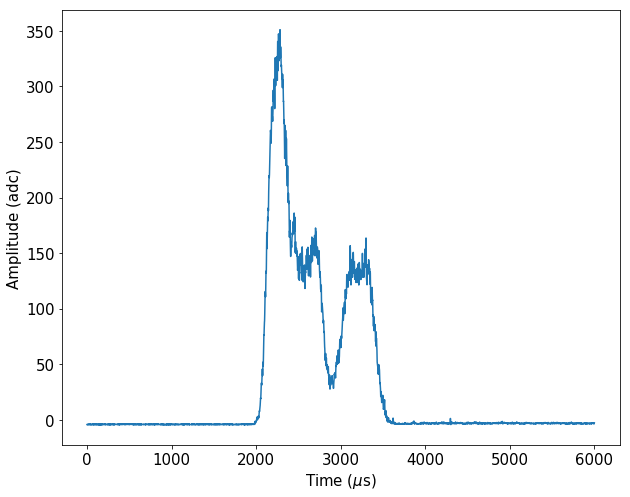

In [13]:
import tables as tb
import invisible_cities.database.load_db as db

h5f = tb.open_file("/Users/Gonzalo/github/NEXTdata/Na22/3614/rwf/dst_waves.gdcsnext.000_3614.root.h5")

rwfs = h5f.root.RD.pmtrwf
cwfs = h5f.root.RD.pmtblr
pmts = db.DataPMT(3614)

evt = 0
rwf = rwfs[evt]
cwf = cwfs[evt]
rwf =  np.sum((rwf - np.mean(rwf, axis=1).reshape(12,1)) / abs(pmts.adc_to_pes.values + 1e-20).reshape(12, 1), axis=0)
cwf = -np.sum((cwf - np.mean(cwf, axis=1).reshape(12,1)) / abs(pmts.adc_to_pes.values + 1e-20).reshape(12, 1), axis=0)

for wf in [rwf, cwf]:
    plt.figure()
    plt.plot(wf)
    labels("Time ($\mu$s)", "Amplitude (adc)")

    plt.figure()
    plt.plot(wf[21400:21600])
    labels("Time ($\mu$s)", "Amplitude (adc)")

    plt.figure()
    plt.plot(wf[24000:30000])
    labels("Time ($\mu$s)", "Amplitude (adc)")

h5f.close()

In [14]:
na = dstf.load_dst(NaDST, "DST", "Events")
na.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


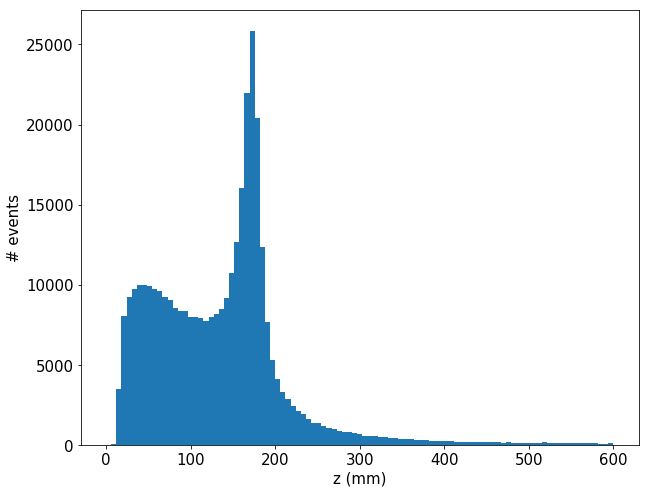

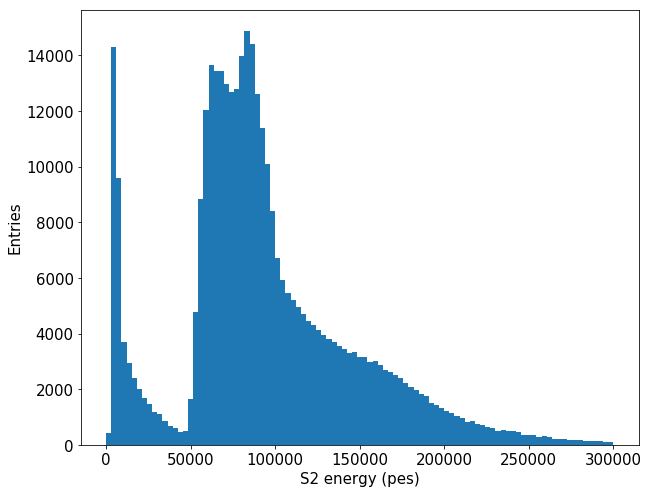

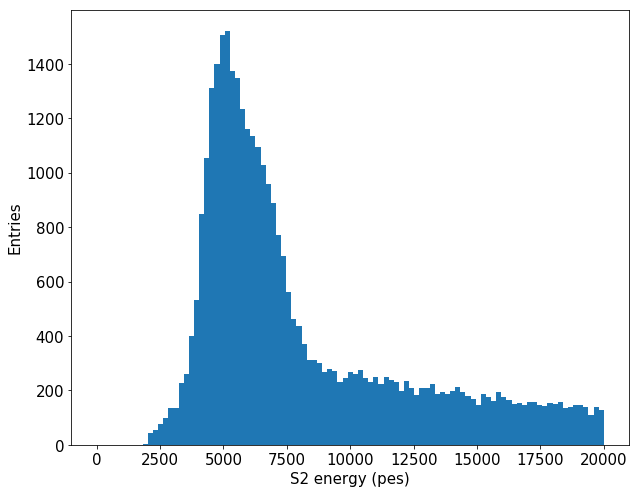

In [15]:
hist(na.Z.values, np.linspace(0, 600, 100))
labels("z (mm)", "# events")


hist(na.S2e, np.linspace(0, 3e5, 100))
labels("S2 energy (pes)", "Entries")

hist(na.S2e, np.linspace(0, 2e4, 100))
labels("S2 energy (pes)", "Entries")

In [16]:
XR = na
XR = XR[coref.in_range(XR.Z  ,   0, 160)]
XR = XR[coref.in_range(XR.S2e, 4e3, 9e3)]


PE = na
PE = PE[coref.in_range(PE.S1e,  100,   150)]
PE = PE[coref.in_range(PE.S2e, 50e3, 110e3)]
#PE = PE[coref.in_range(PE.Z  ,  160,   185)]
#PE = PE[coref.in_range(PE.Y  ,  -20,    20)]
PE = PE[PE.nS2==1]


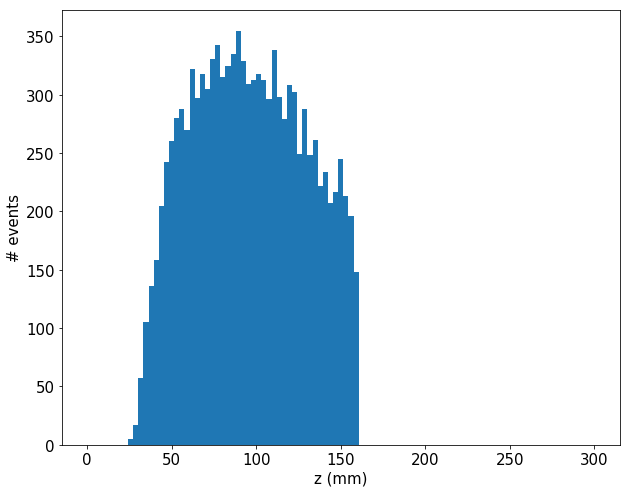

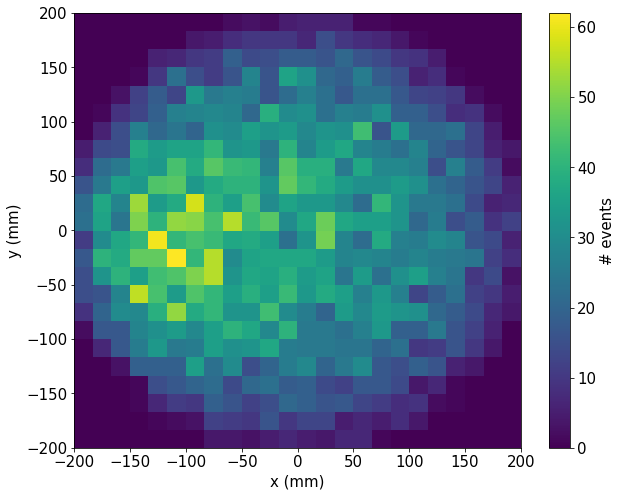

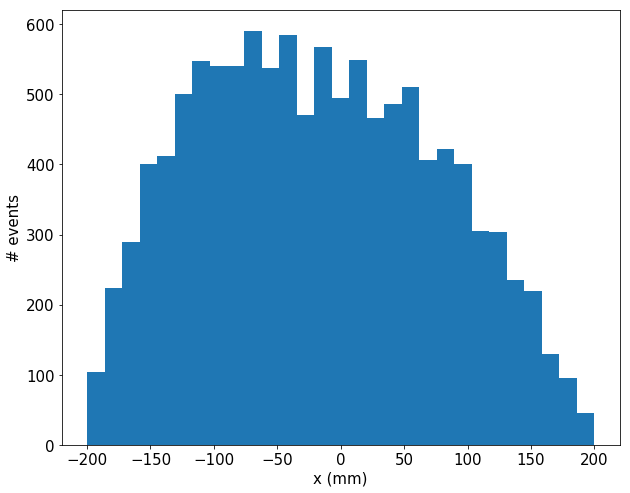

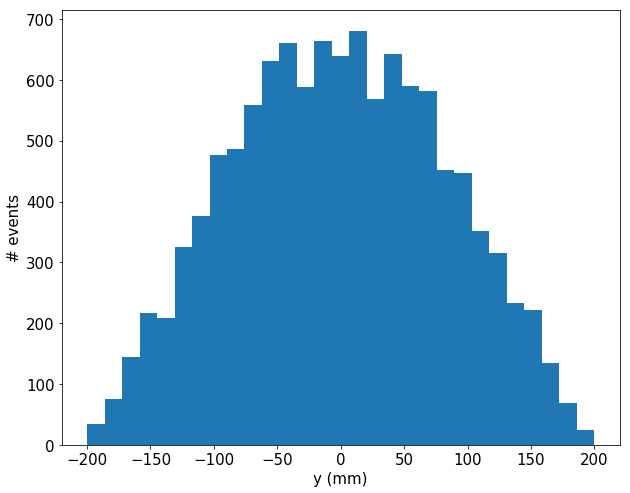

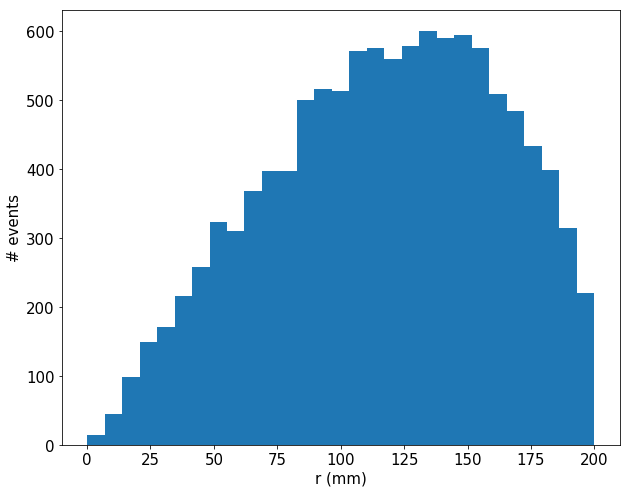

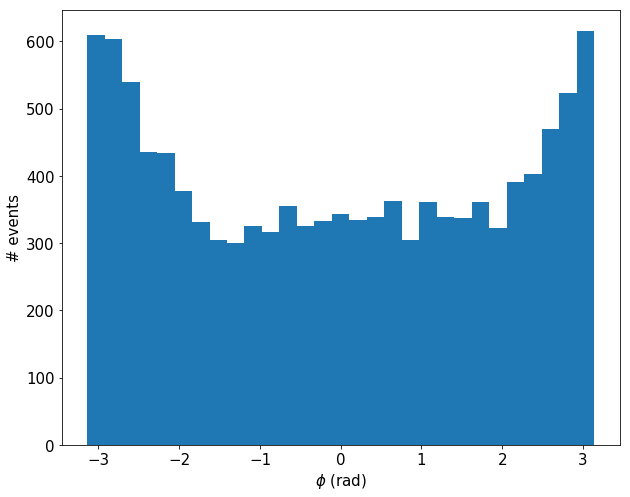

In [17]:
hist(XR.Z.values, np.linspace(0, 300, 100))
labels("z (mm)", "# events")

hist2d(XR.X.values, XR.Y.values, (np.linspace(-200, 200, 25),
                                  np.linspace(-200, 200, 25)))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

hist(XR.X.values, np.linspace(-200, 200, 30))
labels("x (mm)", "# events")

hist(XR.Y.values, np.linspace(-200, 200, 30))
labels("y (mm)", "# events")

hist(XR.R.values, np.linspace(0, 200, 30))
labels("r (mm)", "# events")

hist(XR.Phi.values, np.linspace(-pi, pi, 30))
labels("$\phi$ (rad)", "# events")

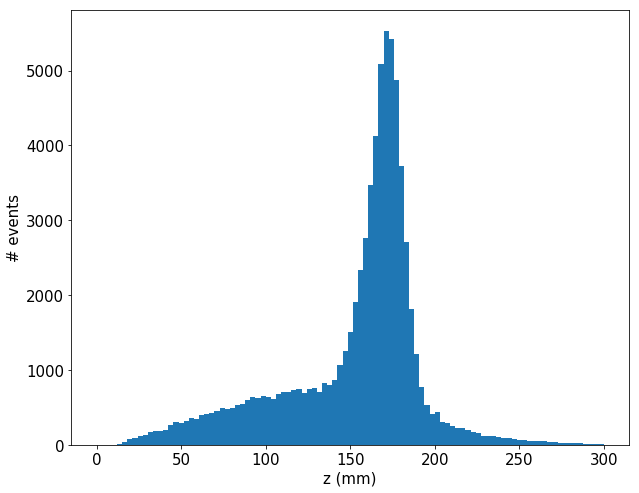

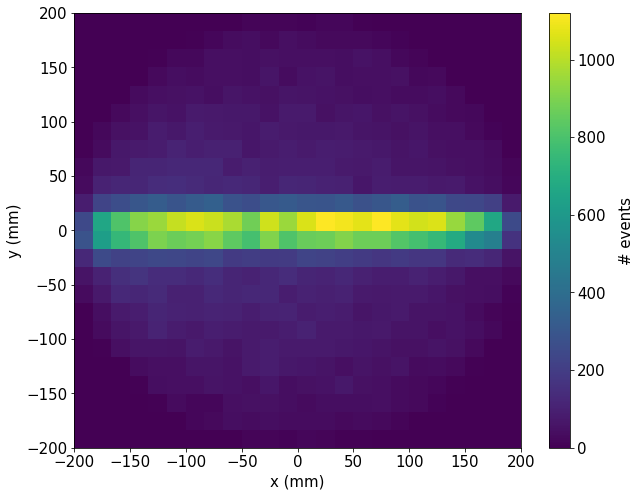

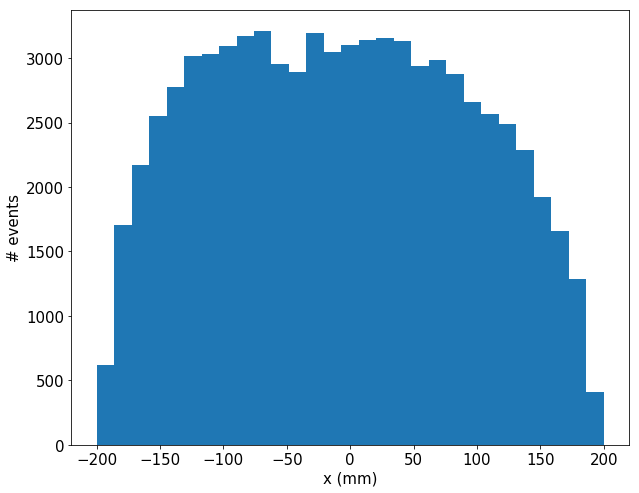

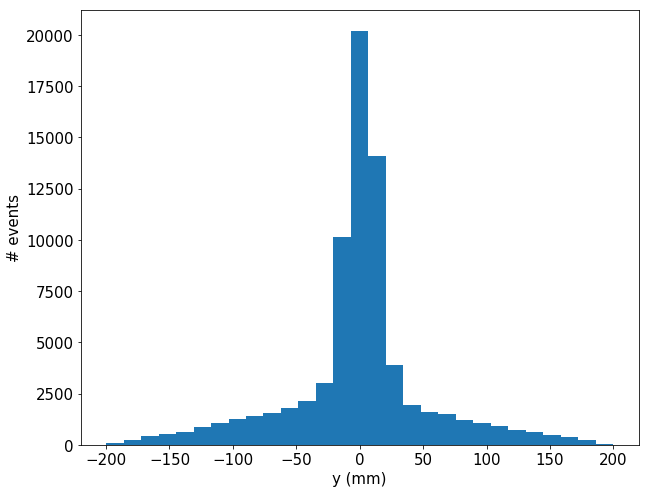

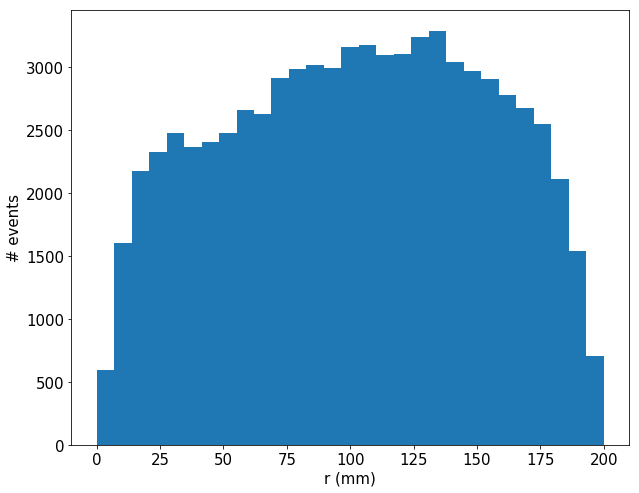

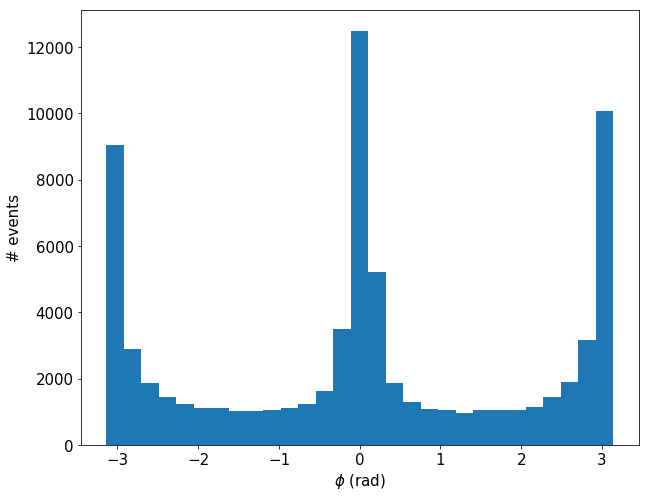

In [18]:
hist(PE.Z.values, np.linspace(0, 300, 100))
labels("z (mm)", "# events")

hist2d(PE.X.values, PE.Y.values, (np.linspace(-200, 200, 25),
                                  np.linspace(-200, 200, 25)))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

hist(PE.X.values, np.linspace(-200, 200, 30))
labels("x (mm)", "# events")

hist(PE.Y.values, np.linspace(-200, 200, 30))
labels("y (mm)", "# events")

hist(PE.R.values, np.linspace(0, 200, 30))
labels("r (mm)", "# events")

hist(PE.Phi.values, np.linspace(-pi, pi, 30))
labels("$\phi$ (rad)", "# events")

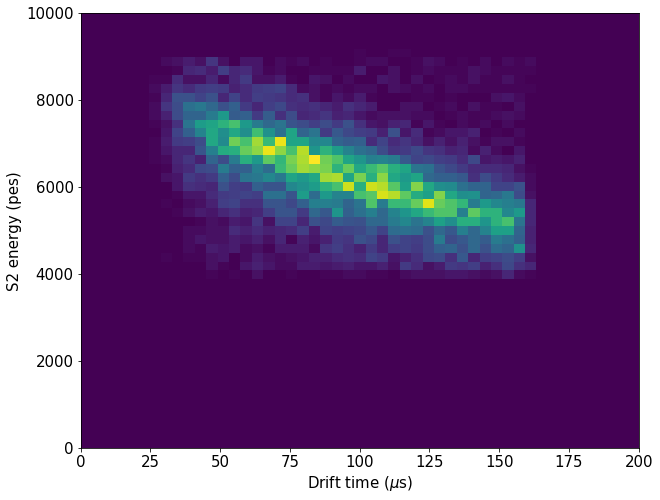

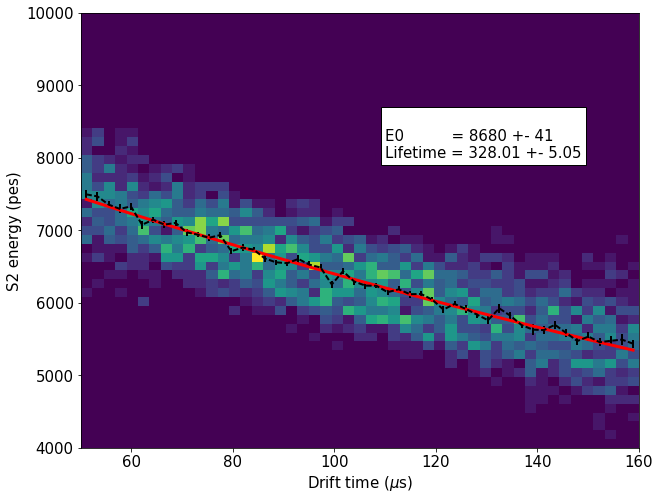

In [19]:
hist2d(XR.Z.values, XR.S2e.values, (np.linspace(0, 200, 50),
                                    np.linspace(0, 1e4, 50)))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

fid = XR[XR.R < 100]

x, y, ye = fitf.profileX(fid.Z.values, fid.S2e.values, 50, (50, 160), (4e3, 1e4))

xr_emin = scp.interpolate.interp1d(x, y - ye*15, fill_value="extrapolate")
xr_emax = scp.interpolate.interp1d(x, y + ye*10, fill_value="extrapolate")
fid     = fid[coref.in_range(fid.S2e, xr_emin(fid.Z), xr_emax(fid.Z))]
x, y, ye = fitf.profileX(fid.Z.values, fid.S2e.values, 50, (50, 160), (4e3, 1e4))
hist2d(fid.Z.values, fid.S2e.values, (np.linspace( 50, 160, 50),
                                      np.linspace(4e3, 1e4, 50)))
plt.errorbar(x, y, ye, fmt=profOpt, lw=2)

sel = coref.in_range(x, 50, 160)
f = fitf.fit(fitf.expo, x, y, (1e4, -2e2), sigma=ye[sel], fit_range=(50, 160))
plt.plot(x[sel], f.fn(x[sel]), fitOpt, lw=3)
plt.text(110, 8e3, """
E0          = {:.0f} +- {:.0f}
Lifetime = {:.2f} +- {:.2f}""".format( f.values[0], f.errors[0],
                                      -f.values[1], f.errors[1]), bbox=dict(facecolor='white'))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

zref = 50
LT = -f.values[1]

7604.18989208


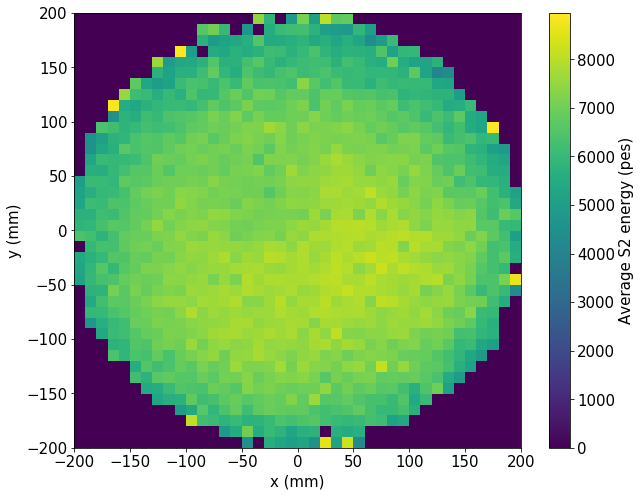

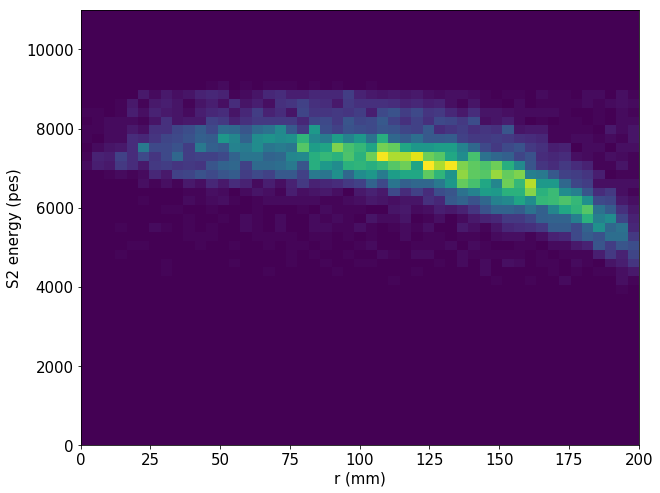

In [20]:
fid = XR[coref.in_range(XR.Z.values, 0, 200)]
fid.S2e *= np.exp((fid.Z.values - zref)/LT)
fid = fid[coref.in_range(fid.S2e.values, 4e3, 9e3)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]
#hist2d(fid.Z, fid.S2e, 100, ((0, 200), (4e3, 12e3)))
#hist2d(fid.R, fid.S2e, 100, ((0, 200), (4e3, 12e3)))
#hist(fid.S2e, 100, (4e3, 12e3))

pf, _, cb = profile_and_scatter(fid.X.values, fid.Y.values, fid.S2e.values,
                                (40, 40), (-200, 200), (-200, 200))
cb.set_label("Average S2 energy (pes)")
labels("x (mm)", "y (mm)")

hist2d(fid.R.values, fid.S2e.values, (np.linspace( 0,  200, 50),
                                      np.linspace( 0, 11e3, 50)))
labels("r (mm)", "S2 energy (pes)")


xycorr = get_xycorr(*pf[:-1])

[  5.96344820e+05   7.46829089e+03   3.06501104e+02   1.41216358e+05
   8.40259837e+03   2.85476402e+02] 7.15227920973 (9.6444769721406711, 1.0583604364723134)


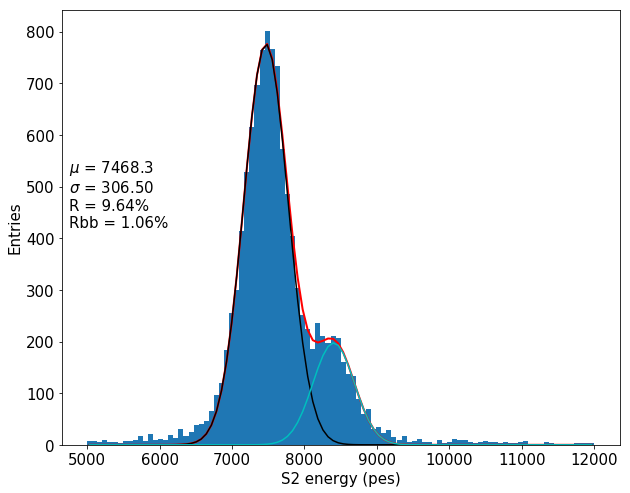

In [21]:
fid = XR [coref.in_range(XR.Z.values, 0, 200)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]

fid.S2e *= np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

y, x, _ = \
hist(fid.S2e, 100, (5e3, 12e3))
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
low  = 1e4, 7000, 1e2, 1e4, 8000, 1e2
seed = 1e6, 7500, 2e2, 1e6, 8500, 3e2
upp  = 1e8, 8000, 6e2, 1e8, 9000, 7e2
f = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(6e3, 9500))
plt.plot(x, f.fn(x), fitOpt, lw=2)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values[:3], 29.6))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values[:3], 29.6))

7619.55456546


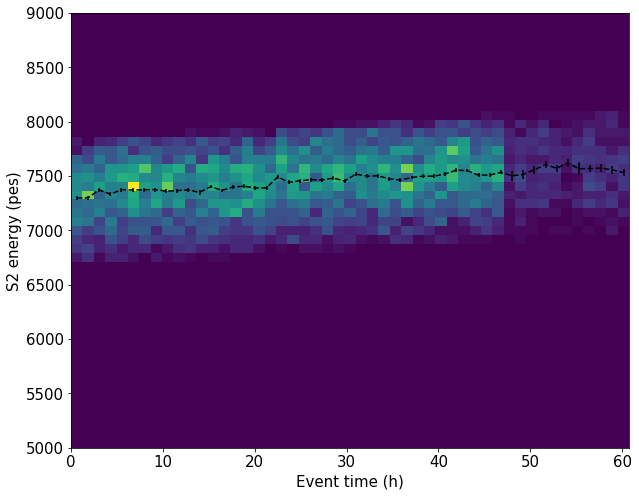

In [22]:
fid = XR [coref.in_range(XR .Z  .values, 0, 200)]
fid = fid[coref.in_range(fid.R  .values, 0, 200)]

T  = fid.time.values / 3600
T -= np.min(T)
E  = fid.S2e.values * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

fid = fid[coref.in_range(E, 6700 + 5*T, 7800 + 5*T)]
T  = fid.time.values / 3600
T -= np.min(T)
E  = fid.S2e.values * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

hist2d(T, E, (np.linspace(  0, np.max(T), 50),
              np.linspace(5e3,       9e3, 50)))

x, y, ye = fitf.profileX(T, E, 50, (0, np.max(T)))
plt.errorbar(x, y, ye, fmt=profOpt)
labels("Event time (h)", "S2 energy (pes)")

tcorr = get_tcorr(x, y)

[  5.99732358e+05   7.64735324e+03   3.06576107e+02   1.36639463e+05
   8.61051407e+03   2.68372470e+02] 7.91409962904 (9.4209568966440695, 1.0338319104209521)


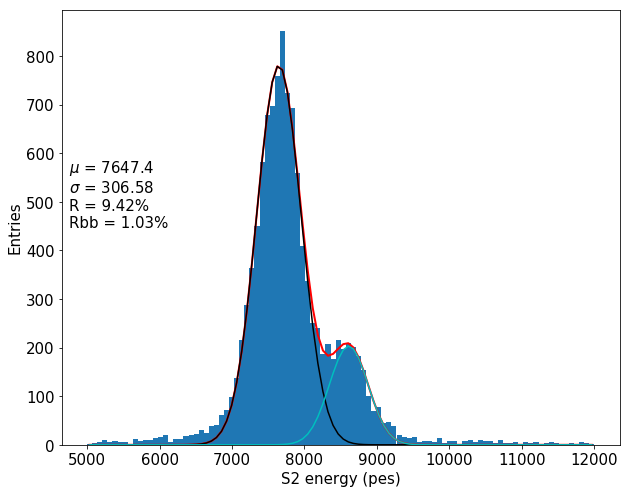

In [23]:
fid = XR [coref.in_range(XR.Z.values, 0, 200)]
fid = fid[coref.in_range(fid.R.values, 0, 200)]

T  = fid.time.values / 3600
T -= np.min(T)
fid.S2e *= np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values) * tcorr(T)

y, x, _ = \
hist(fid.S2e, 100, (5e3, 12e3))
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
low  = 1e4, 7000, 1e2, 1e4, 8000, 1e2
seed = 1e6, 7500, 2e2, 1e6, 8500, 3e2
upp  = 1e8, 8000, 6e2, 1e8, 9000, 7e2
f = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(6e3, 9500))
plt.plot(x, f.fn(x), fitOpt, lw=2)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values[:3], 29.6))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values[:3], 29.6))

In [24]:
PE = na
PE = PE[coref.in_range(PE.S1e,  100,   150)]
PE = PE[coref.in_range(PE.S2e, 50e3, 110e3)]
PE = PE[coref.in_range(PE.Z  ,  160,   185)]
PE = PE[coref.in_range(PE.Y  ,  -20,    20)]
PE = PE[PE.nS2==1]

[  1.20039089e+07   1.23417235e+05   5.93699732e+03] 0.843135364042


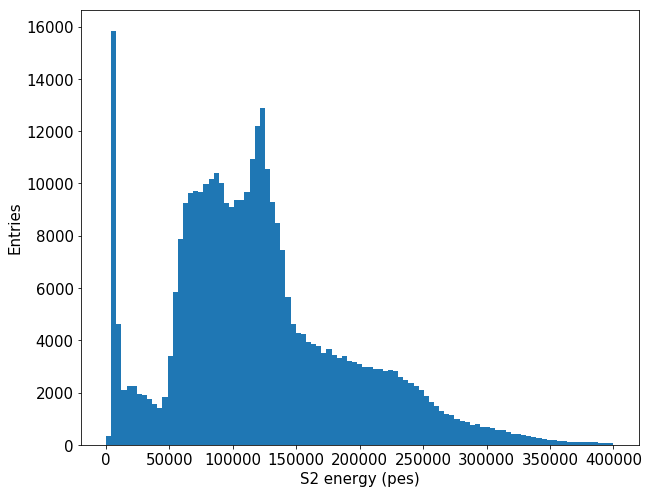

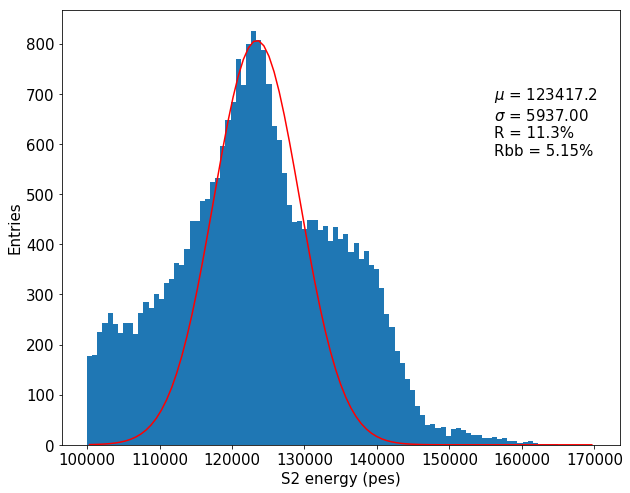

In [25]:
hist(na.S2e * np.exp((na.Z.values - zref)/LT), np.linspace(0, 4e5, 100))
labels("S2 energy (pes)", "Entries")

y, x, _ = \
hist(PE.S2e * np.exp((PE.Z.values - zref)/LT), np.linspace(10e4, 17e4, 100))
x = x[:-1] + np.diff(x) * 0.5

f = fitf.fit(fitf.gauss, x, y, (1e7, 122e3, 1e3), fit_range=(118e3, 125e3))
print(f.values, f.chi2)
plt.plot(x, f.fn(x), fitOpt)
plt.text(plt.xlim()[1]*0.9, plt.ylim()[1]*2/3, gausstext(f.values[:3], 511))

labels("S2 energy (pes)", "Entries")

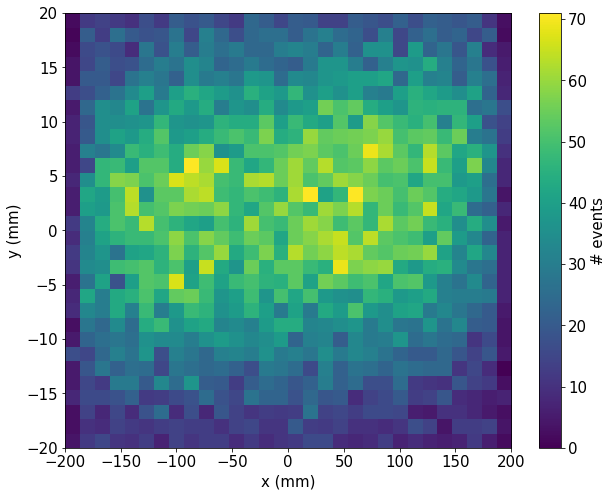

In [26]:
hist2d(PE.X.values, PE.Y.values, 30, ((-200, 200), (-20, 20)))
labels("x (mm)", "y (mm)")
plt.colorbar().set_label("# events")

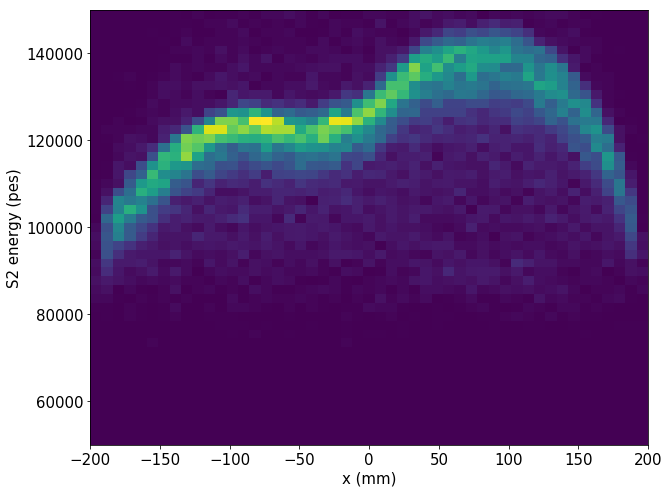

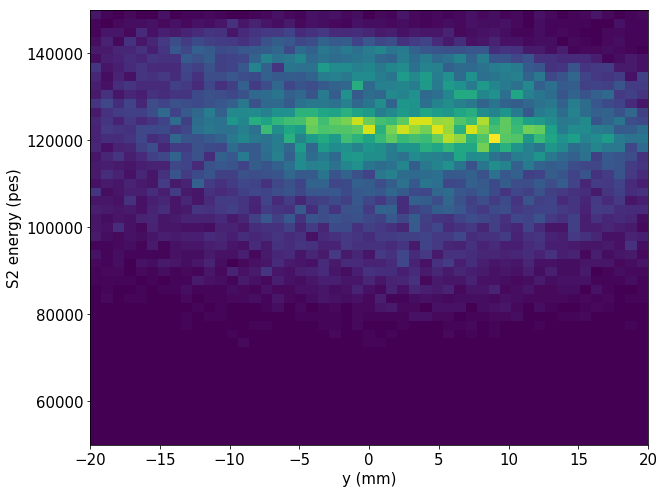

In [27]:
E = np.array(PE.S2e.values) * np.exp((PE.Z.values - zref)/LT)

hist2d(PE.X, E, (np.linspace(-200,  200, 50),
                 np.linspace( 5e4, 15e4, 50)))
#x, y, _ = fitf.profileX(PE.X.values, E, 50, (-200, 200))
#plt.plot(x, y, profOpt)
labels("x (mm)", "S2 energy (pes)")

hist2d(PE.Y, E, (np.linspace( -20,   20, 50),
                 np.linspace( 5e4, 15e4, 50)))
#x, y, _ = fitf.profileX(PE.X.values, E, 50, (-200, 200))
#plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")


"""hist2d(PE.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PE.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PE.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PE.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PE.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PE.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")""";

In [28]:
_x     = np.array([ -200,  -150,  -100,   -50,     0,    50,   100,   125,   160,   200])
_emin  = np.array([ 85e3, 100e3, 115e3, 112e3, 117e3, 125e3, 125e3, 118e3, 110e3,  88e3])
_emax  = np.array([105e3, 120e3, 130e3, 128e3, 132e3, 147e3, 147e3, 145e3, 133e3, 112e3])

_eminfid = scp.interpolate.interp1d(_x, _emin, fill_value="extrapolate")
_emaxfid = scp.interpolate.interp1d(_x, _emax, fill_value="extrapolate")

E     = np.array(PE.S2e.values) * np.exp((PE.Z.values - zref)/LT)
PEfid = PE[coref.in_range(E, _eminfid(PE.X), _emaxfid(PE.X))]

"""hist2d(PE.X, E, 50, ((-200, 200), (5e4, 15e4)))
x, y, _ = fitf.profileX(PE.X.values, E, 50, (-200, 200))
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")
labels("x (mm)", "S2 energy (pes)")
""";

127689.333916


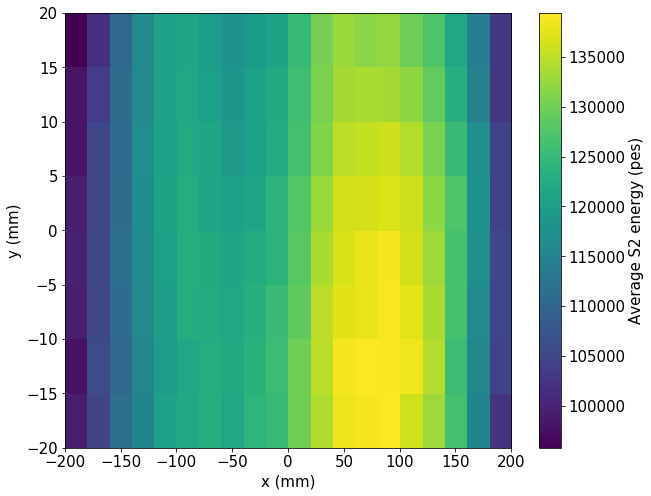

In [29]:
fid = PEfid[coref.in_range(PEfid.Z.values, 0, 200)]
fid.S2e *= np.exp((fid.Z.values - zref)/LT)
#fid = fid[coref.in_range(fid.R.values, 0, 200)]
#hist2d(fid.Z, fid.S2e, 100, ((0, 200), (4e3, 12e3)))
#hist2d(fid.R, fid.S2e, 100, ((0, 200), (4e3, 12e3)))
#hist(fid.S2e, 100, (4e3, 12e3))

pf, _, cb = profile_and_scatter(fid.X.values, fid.Y.values, fid.S2e.values,
                                (20, 8), (-200, 200), (-20, 20))
cb.set_label("Average S2 energy (pes)")
labels("x (mm)", "y (mm)")

xycorr = get_xycorr(*pf[:-1])

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  8.09365650e+06   1.29643460e+05   3.17107870e+03   3.27834251e+06
   1.22742057e+05   3.37597405e+03] 2.06444625764 (5.7480993916597036, 2.6208597416858832)


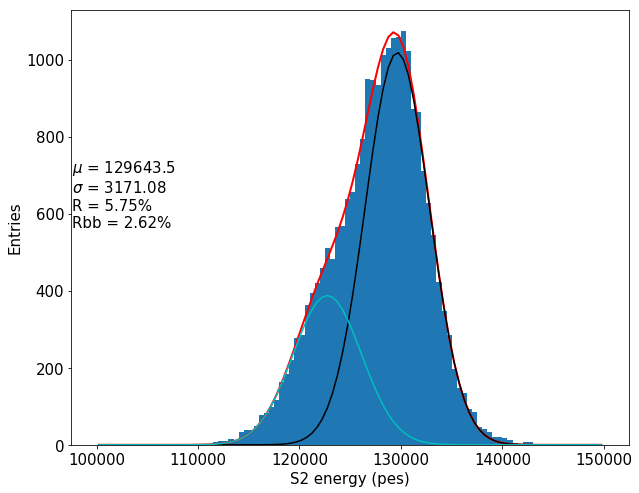

In [30]:
fid = PEfid[coref.in_range(PEfid.Z.values, 0, 200)]

E = fid.S2e.values * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

y, x, _ = \
hist(E, 100, (100e3, 150e3))
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
low  = 1e5, 127e3, 1e2, 1e4, 118e3, 1e2
seed = 1e7, 130e3, 2e3, 1e6, 122e3, 3e3
upp  = 1e9, 132e3, 6e4, 1e9, 125e3, 7e4

f = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
plt.plot(x, f.fn(x), fitOpt, lw=2)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values[:3], 511))

131102.745435


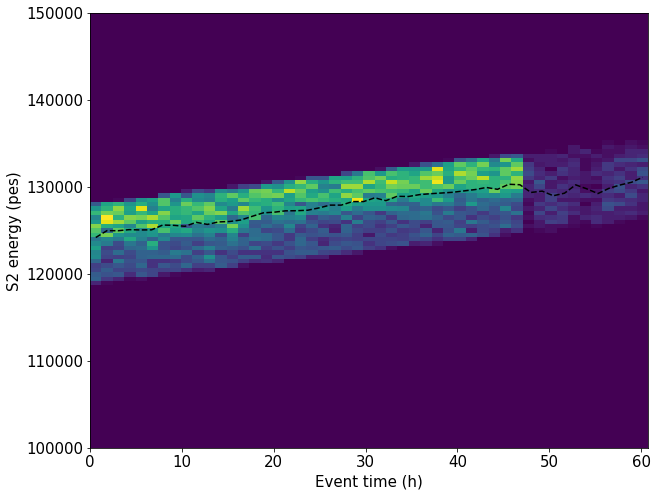

In [31]:
T  = PEfid.time.values / 3600
T -= np.min(T)
E  = PEfid.S2e.values * np.exp((PEfid.Z.values - zref)/LT) * xycorr(PEfid.X.values, PEfid.Y.values)

lowE = 119e3 + 6*3600/175*T
uppE = 128e3 + 6*3600/175*T
fid = PEfid[coref.in_range(E, lowE, uppE)]

T  = fid.time.values / 3600
T -= np.min(T)
E  = fid.S2e.values * np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values)

hist2d(T, E, (np.linspace(0, np.max(T),  50),
              np.linspace(100e3, 150e3, 100)))
x, y, _ = fitf.profileX(T, E, 50, (0, np.max(T)))
plt.plot(x, y, profOpt)
labels("Event time (h)", "S2 energy (pes)")

tcorr = get_tcorr(x, y)

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  8.63647107e+06   1.32839965e+05   2.71261054e+03   2.56211648e+06
   1.25326216e+05   2.66126694e+03] 4.26819011312 (4.7987326386669089, 2.1879936874516623)


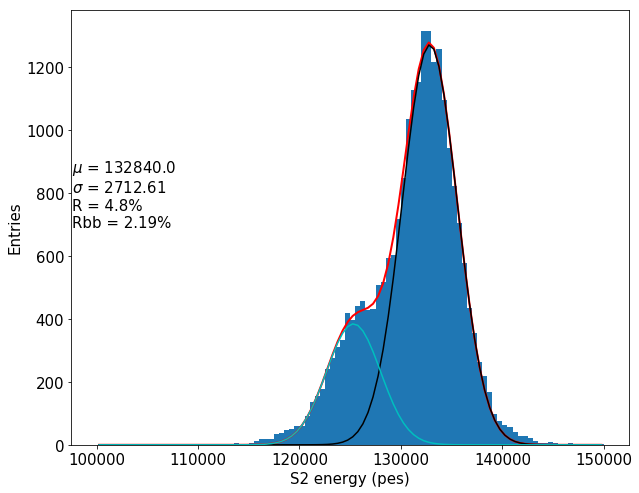

In [36]:
fid = PEfid[coref.in_range(PEfid.Z.values, 0, 200)]
#fid = fid[coref.in_range(fid.R.values, 0, 200)]

T  = fid.time.values / 3600
T -= np.min(T)
fid.S2e *= np.exp((fid.Z.values - zref)/LT) * xycorr(fid.X.values, fid.Y.values) * tcorr(T)

y, x, _ = \
hist(fid.S2e, 100, (100e3, 150e3))
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
low  = 1e5, 127e3, 1e2, 1e4, 118e3, 1e2
seed = 1e7, 130e3, 2e3, 1e6, 122e3, 3e3
upp  = 1e9, 136e3, 6e4, 1e9, 128e3, 7e4
f = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
plt.plot(x, f.fn(x), fitOpt, lw=2)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(plt.xlim()[0] + 100, plt.ylim()[1]/2, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2, reso(f.values[:3], 511))

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[ 1185933.17024232   130177.62909501     4903.1511565    649540.22737673
   121916.15303117     4667.90641072] 1.03635127319
[ 2339096.16888441   129279.3318393      3840.73640276   466538.26895371
   120869.93467481     2971.94945482] 1.67013885517
[ 2050817.469588     129648.06248988     2548.00944475   832619.13760865
   123480.56355568     2743.44823078] 1.60420368157
[ 2077676.02341583   129175.23017642     2345.37043924   644459.66347675
   122511.1953881      2244.00054651] 0.736380183589
[ 2152795.16368888   129087.96137009     2753.89830417   653589.60294988
   122662.33246779     2626.516555  ] 0.633220537227
[ 1388014.69743238   130411.17589339     2429.53203507  1548422.20119298
   125278.00089546     4275.22820517] 1.13769555996
[  966600.89284476   131143.20666831     2424.58066885  1781726.47089626
   126124.38902755     4298.20965817] 1.09317144428
[  4.34180420e+05   1.32991690e+05   2.12438866e+03   2.23213686e+06
   1.27081210e+05   5.22809488e+03] 1.87925413598
[  1

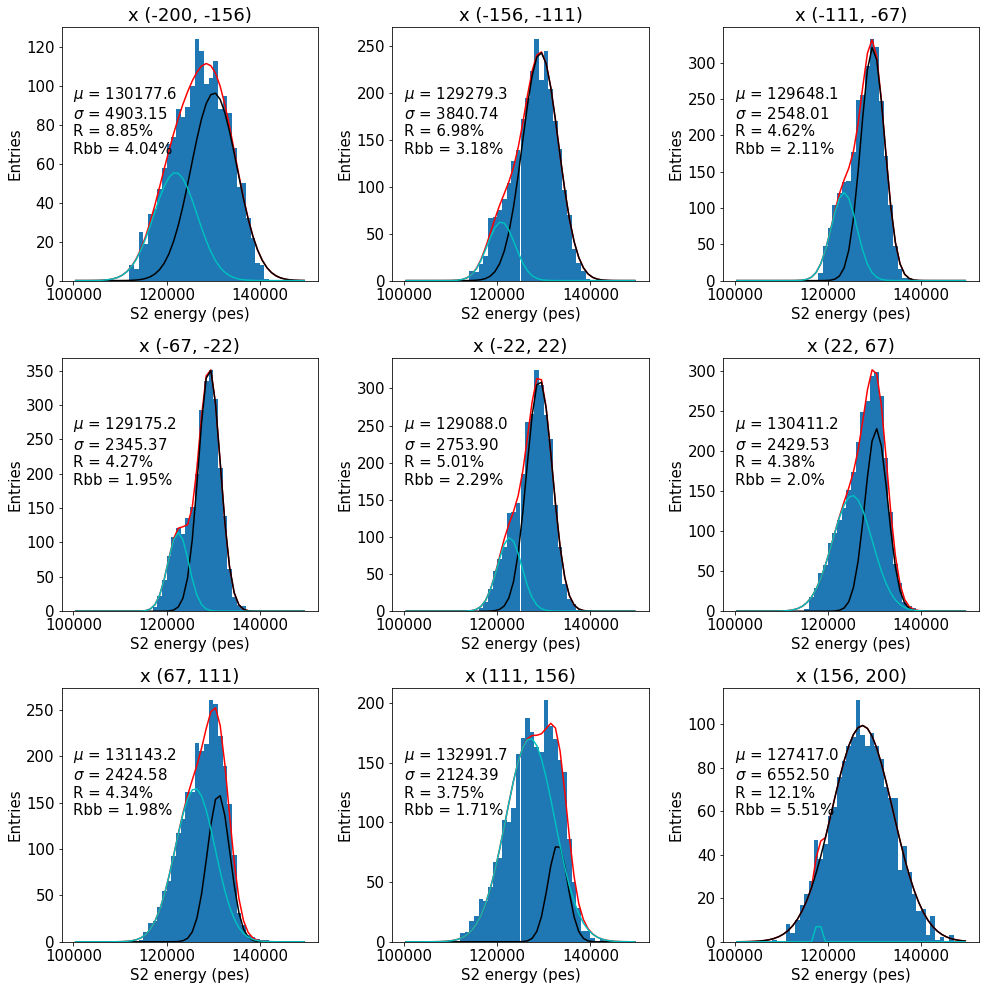

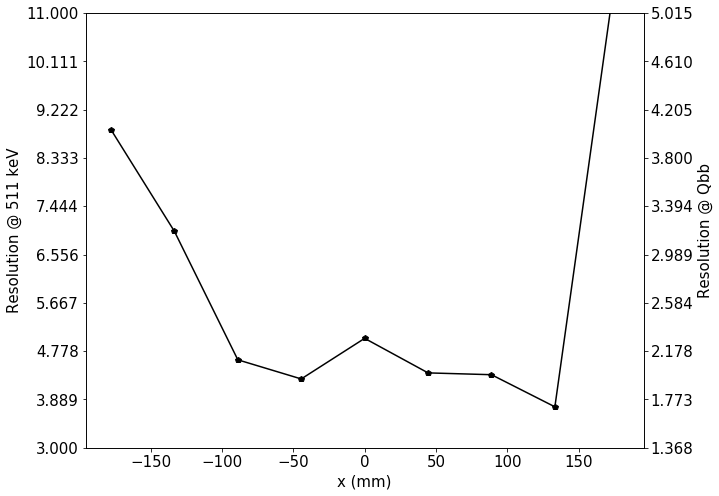

In [37]:
xlim = np.linspace(-200, 200, 10, endpoint=True)

E = PEfid.S2e.values * np.exp((PEfid.Z.values - zref)/LT) * xycorr(PEfid.X.values, PEfid.Y.values) * tcorr(PEfid.time.values)
R   = []
Rbb = []
plt.figure().set_size_inches(14, 14)
for i in range(9):
    EX = E[coref.in_range(PEfid.X.values, xlim[i], xlim[i+1])]

    plt.subplot(3, 3, i+1)
    y, x, _ = \
    plt.hist(EX, 50, (100e3, 150e3))
    x = x[:-1] + np.diff(x) * 0.5
    labels("S2 energy (pes)", "Entries")

    fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
    low  = 1e5, 127e3, 1e2, 1e4, 118e3, 1e2
    seed = 1e7, 130e3, 2e3, 1e6, 122e3, 3e3
    upp  = 1e9, 136e3, 6e4, 1e9, 128e3, 7e4
    f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
    plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
    plt.text(100e3, plt.ylim()[1]/2, gausstext(f.values[:3], 511))
    plt.title("x ({:.0f}, {:.0f})".format(xlim[i], xlim[i+1]))
    print(f.values, f.chi2)

    res, resbb = reso(f.values[:3], 511)
    R  .append(res)
    Rbb.append(resbb)
plt.tight_layout()

xlim = xlim[:-1] + np.diff(xlim) * 0.5
plt.figure()
plt.plot(xlim, R  , "pk-")
plt.ylim(3, 11)
plt.yticks(np.linspace(3, 11, 10))
labels("x (mm)", "Resolution @ 511 keV")

ax2 = plt.gca().twinx()
#ax2.plot(xlim, R, "pk-")
ax2.set_ylim(3 * (511/2458)**0.5, 11 * (511/2458)**0.5)
ax2.set_yticks(np.linspace(3, 11, 10) * (511/2458)**0.5)
ax2.set_ylabel("Resolution @ Qbb");